In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(py['main'])
import Invest
from DataBase_wheels import small_updates
os.chdir(curr)
data_folder = os.getcwd()+'\\Data\\IO'
gams_folder = os.getcwd()+'\\gamsmodels\\Itory'

## Investment sector with inventory sector

To account for inventory investments in data a sector is included to handle this. This sector is very simple:
* The sector demands final goods (a,b,a_F,b_F), but produces no outputs.
* There are still some taxes included from this sector; these are accounted for by defining the difference between the price before and after taxes for the inputs they use.

The current module does not have a proper theory of inventory investments underlying it; thus the investment demand/supply are modelled as simple AR(1) series converging on no investments. The demand for inventory goods are defined as: 
$$\begin{align}
    qD[t,s,n]  = (0,9) qD[t-1,s,n]
\end{align}$$
defined for $t\in\lbrace tx0E\rbrace $, $(s,n)\in\lbrace itoryD[s,n]\rbrace$.

Beyond this model for the demand for inventory goods, the sector itself works as the other investment sectors: The sector demands goods defined by some nesting tree.

### *1: Read in data*

*Load IO data:*

In [2]:
GE_data = DataBase.GPM_database(pickle_path=data_folder+'\\GE_data')

*Load global settings:*

In [3]:
with open(data_folder+'\\Ex1_gs',"rb") as file:
    gs = pickle.load(file)

*subset data:*

In [4]:
GE_itory = small_updates.subset_db(GE_data.copy(),GE_data.get('s_itory'))
for var in GE_itory.variables_flat:
    GE_itory[var] = DataBase_wheels.repeat_variable_windex(GE_itory.get(var),gs.get('t0'))

### *2: Initialize module and run*

In [5]:
name_module = 'itory'
gm_itory = Invest.itoryD(work_folder=work_folder,databases=[GE_itory],gs_v=gs,**{'data_folder':gams_folder,'name':name_module})
gm_itory.write_and_run(kwargs_init={'check_variables':True},overwrite=True)

Export as pickle:

In [6]:
db = gm_itory.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_itory.model.database.symbols];
gm_itory.model.database.merge_dbs(gm_itory.model.database,db,'second')
gm_itory.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\Itory\\gmspython_itory'

*Inspect the solution:*

{'maxdiff': 0.0, 'plotdiff': None}


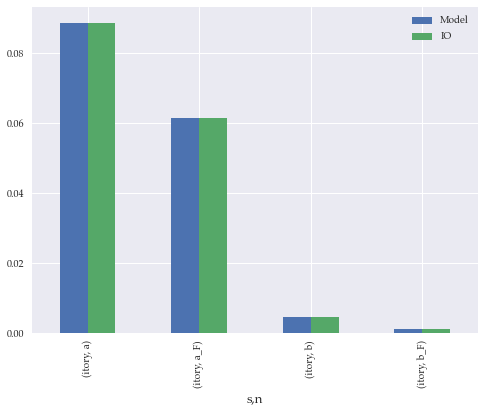

In [10]:
var,year,kwargs = 'qD',1, {'level':'t'}
print(diagnostics.compare_data.std_diagnostics_var(db,GE_data,var,xs=year,plot=False,**kwargs))
pd.DataFrame({'Model': diagnostics.compare_data.get_db1(db,GE_data,var,xs=year,**kwargs), 'IO': diagnostics.compare_data.get_db2(db,GE_data,var,xs=year,**kwargs)}).plot.bar(figsize=(8,6));